In [1]:
import sys, os; sys.path.insert(0, "/".join(os.getcwd().split("/")[:-1])); os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import Reporter, Table
import torch
import math

In [3]:
# Theming
COLORS = ['#2196F3', '#EF5350', '#81C784', '#FF9800', '#3F51B5', '#FFCA28', '#F48FB1', '#673AB7', '#AED581', '#795548']
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=COLORS)
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.color'] = '#CCCCCC'
plt.rcParams['figure.figsize'] = (8, 4.5) # 16/9 aspect ratio
font = {
        'size'   : 14}

plt.rc('font', **font)

In [4]:
# Get result table and event reporter
rTable = Table("results/resultTable.json").export()
OUT_FIGS = "results/figs"

if not os.path.exists(OUT_FIGS):
    os.makedirs(OUT_FIGS)

In [5]:
rTable

,RunId,Category,Experiment,Hyperparameters,Configuration,accuracy,precision,crossEntropy,Status,Last Modified
Run Id,,,,,,,,,,
1,1,defaultCategory,experiments.experiment1,cpu:False\nfract:1.0,configs/E_s.yml,0.601002,0.588940,0.886896,CREATED,2024-11-08 20:26:11.595033
2,2,defaultCategory,experiments.experiment1,cpu:False\nfract:0.1,configs/E_s.yml,0.590376,0.585658,0.901660,CREATED,2024-11-10 11:51:32.359919
3,3,defaultCategory,experiments.experiment1,cpu:False\nfract:0.1,configs/E_m.yml,0.598316,0.552634,0.887066,CREATED,2024-11-11 13:52:20.977199
4,4,defaultCategory,experiments.experiment1,cpu:False\nfract:0.1,configs/C_s.yml,0.371832,0.185916,1.094200,CREATED,2024-11-12 16:47:22.396668
5,5,defaultCategory,experiments.experiment1,cpu:False\nfract:0.1,configs/C_t.yml,0.371832,0.185916,1.093272,CREATED,2024-11-13 08:46:34.801265
6,6,defaultCategory,experiments.experiment1,cpu:False\nfract:0.1,configs/V_16.yml,0.373696,0.186848,1.093082,CREATED,2024-11-14 07:10:52.446584
7,7,defaultCategory,experiments.experiment1,comment:New training loop and data processing\...,configs/E_s.yml,0.595751,0.565942,0.890143,CREATED,2024-11-15 22:10:56.677439
8,8,defaultCategory,experiments.experiment1,comment:New training loop and data processing\...,configs/E_s.yml,0.595996,0.554180,0.890694,CREATED,2024-11-17 11:25:33.294967
9,9,defaultCategory,experiments.experiment2,dataset:small\ncpu:False\nnoscaler:False\nfrac...,configs/paper_2.yml,0.530109,0.482563,0.709141,CREATED,2024-11-19 12:31:31.387381


In [6]:
NAIVE_PERF = {
    "small": 53.70,
    "smallUS": 53.74,
    "huge0.1": 51.28,
    "huge2d0.2": 49.93,
    "huge5d0.5": 51.93,
    "huge10d1.": 53.26,
    "huge2d0.1": 50.09,
    "huge5d0.1": 51.97,
    "huge10d0.1": 52.56,
}

# TODO
- [X] Find naive performances for each datasets (and compare)
- [X] Visual comparaison between our images and their images
- [X] Figure showing how much money you would make if their algorithm would work
- [ ] Cite paper for RF

# Reimplementation
The first step of our investigation is to try to reproduce the result of the paper. They add 92% of accuracy on the Taiwan50 dataset.
We implemented their methodology as it was described. We used the same model, the same number of datapoints and the same method of rendering.

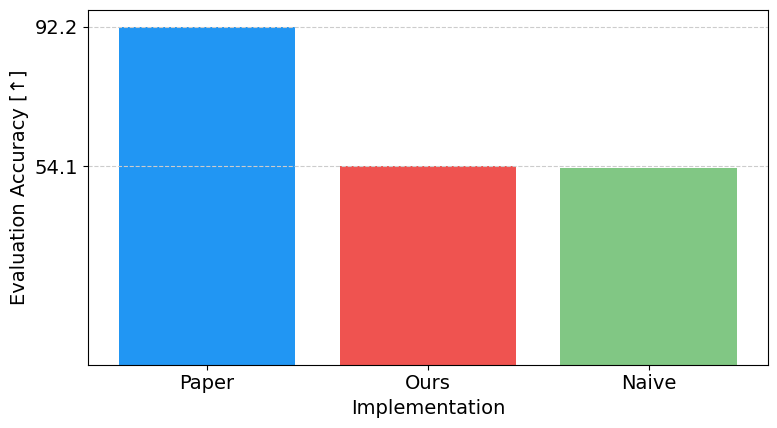

In [7]:
runID = 10
perf = rTable.loc[runID]
our_acc = perf["accuracy"] * 100
their_acc = 92.2
names = ["Paper", "Ours", "Naive"]
plt.bar(names, [their_acc, our_acc, NAIVE_PERF["small"]], color=COLORS[:3])
plt.yticks([our_acc, their_acc])
# plt.ylim(0.60, 0.62)
plt.ylabel("Evaluation Accuracy [↑]")
plt.grid(axis="y")
plt.xlabel("Implementation")
if OUT_FIGS is not None:
    plt.subplots_adjust(bottom=0.15)
    plt.tight_layout()
    plt.savefig(f"{OUT_FIGS}/reimplementation.svg")

Well, this doesn't look the same. We revised our code, and we didn't find any mismatch between our implementatio and the detailed methodology. However, it fells kinf of fishy to be able to predict the **future** 92% of the time. (It is a whole other level of accuracy). With that accuracy, one could become the richest man in the world really quickly (**TODO: Make figure**) To know more, we tried to investigate.

# New representation
The authors of the paper used matplotlib finance to render the time series in a visual representation. However, this technique is really slow (around 2fps). We implemented our own renderer (**TODO: show image comparaison**), Which is 1000x faster (Around 2,000fps). Being able to use that rendering method would greatly speed up experiment, and make it possible to make bigger experiment. Here, we test the difference in performances between both methods.

/tmp/ipykernel_34089/2194770310.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  images = [torch.load(f"saved_models/{rid}/inputs.pth")[0].permute(0, 2, 3, 1).numpy() for

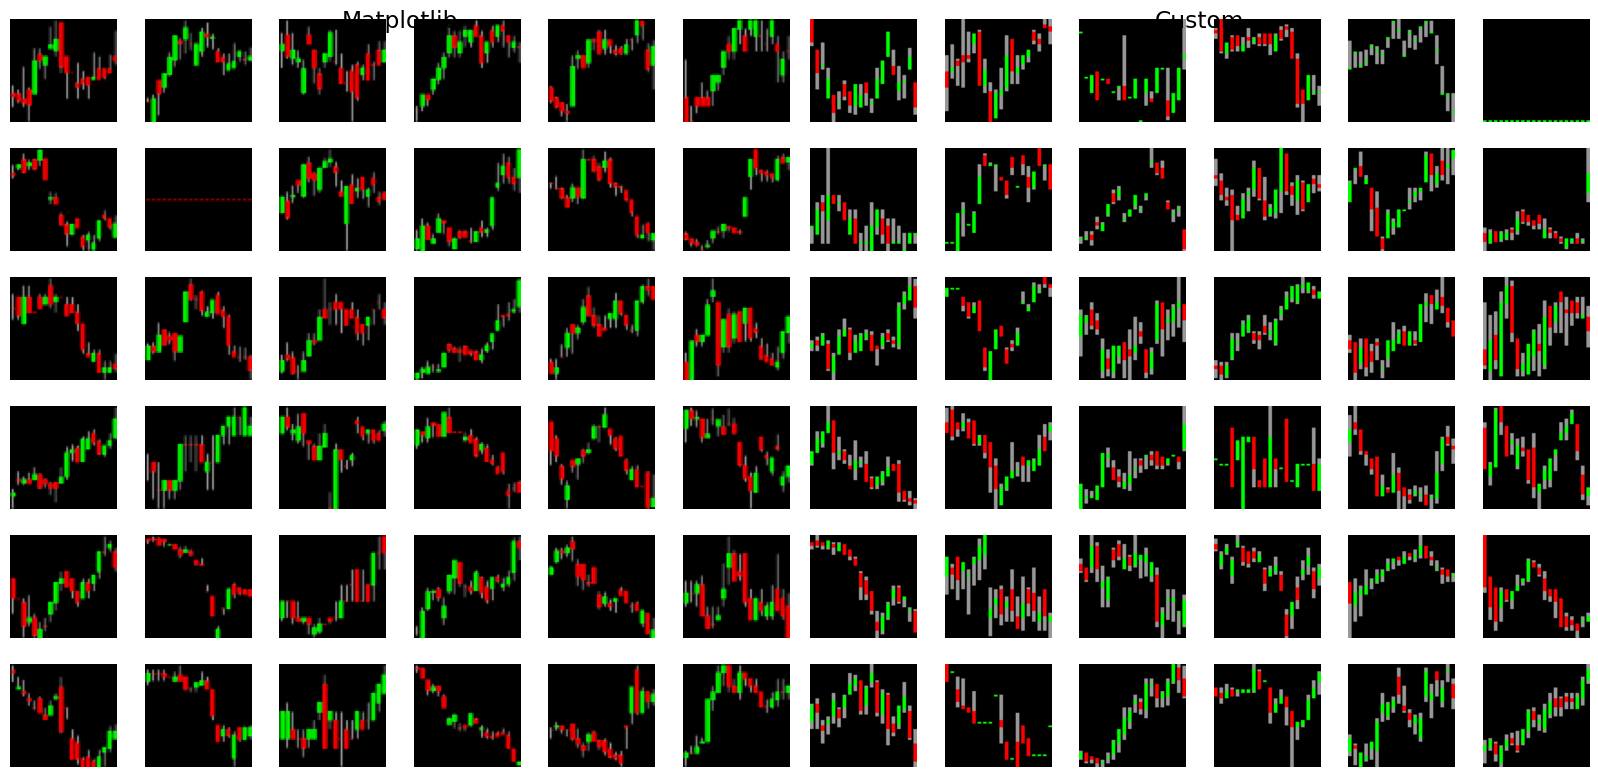

In [8]:
runID = [10, 33]
N = 36
images = [torch.load(f"saved_models/{rid}/inputs.pth")[0].permute(0, 2, 3, 1).numpy() for rid in runID]

fig = plt.figure(figsize=(16, 8), layout='constrained')

subfigs = fig.subfigures(1, 2, wspace=0.05, squeeze=True)

axsLeft = subfigs[0].subplots(int(math.sqrt(N)), int(math.sqrt(N)))
for i, ax in enumerate(axsLeft.flatten()):
    ax.imshow(images[0][i])
    ax.axis("off")
subfigs[0].suptitle("Matplotlib")

axsRight = subfigs[1].subplots(int(math.sqrt(N)), int(math.sqrt(N)))
for i, ax in enumerate(axsRight.flatten()):
    ax.imshow(images[1][i])
    ax.axis("off")
subfigs[1].suptitle("Custom")

if OUT_FIGS is not None:
    plt.subplots_adjust(bottom=0.15, left=0.20)
    plt.tight_layout()
    plt.savefig(f"{OUT_FIGS}/image_comp.svg")

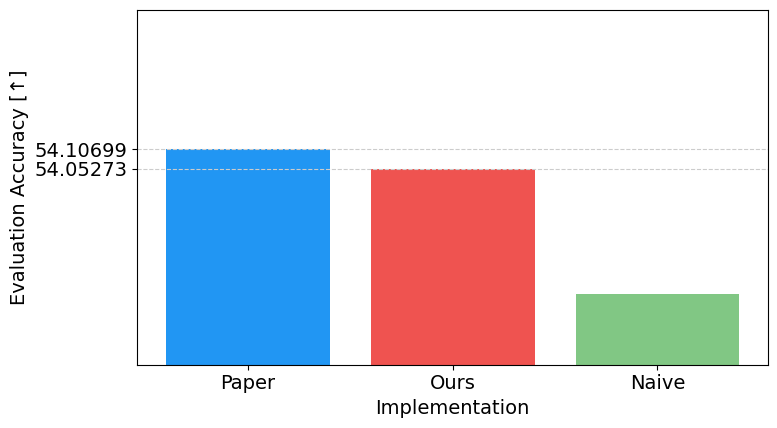

In [9]:
runID = [10, 11]
acc = [100 * rTable.loc[rid]["accuracy"] for rid in runID]
names = ["Paper", "Ours", "Naive"]
plt.bar(names, acc + [NAIVE_PERF["small"]], color=COLORS[:3])
plt.yticks(acc)
plt.ylim(53.5, 54.5)
plt.ylabel("Evaluation Accuracy [↑]")
plt.grid(axis="y")
plt.xlabel("Implementation")
if OUT_FIGS is not None:
    plt.subplots_adjust(bottom=0.15, left=0.20)
    plt.tight_layout()
    plt.savefig(f"{OUT_FIGS}/new_repr_acc.svg")

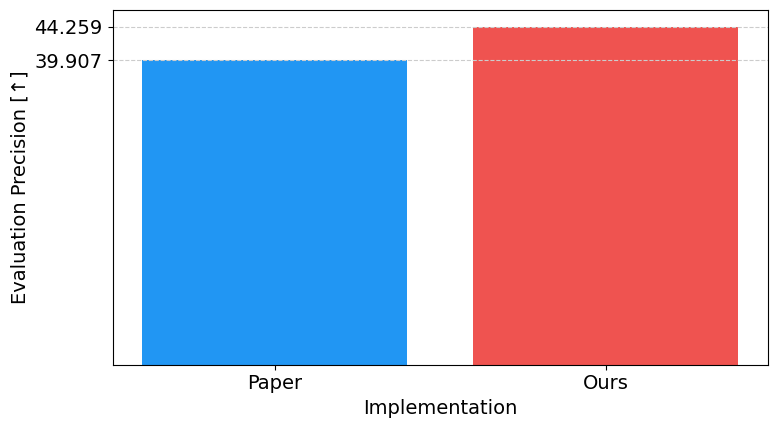

In [10]:
runID = [10, 11]
acc = [100 * rTable.loc[rid]["precision"] for rid in runID]
names = ["Paper", "Ours"]
plt.bar(names, acc, color=COLORS[:2])
plt.yticks(acc)
# plt.ylim(53., 54.5)
plt.ylabel("Evaluation Precision [↑]")
plt.grid(axis="y")
plt.xlabel("Implementation")
if OUT_FIGS is not None:
    plt.subplots_adjust(bottom=0.15, left=0.20)
    plt.tight_layout()
    plt.savefig(f"{OUT_FIGS}/new_repr_precision.svg")

Since the difference in performances is small, we continue to use our rendering method for the rest of the project

# Problem: Task or model
In this section, we wanted to see if the problem was the task that was too hard or the model that was incapable of learning useful features. We created two alternative task that doesn't requires to predict the future. (Task are described in the lab report for experiment 2 in the method section)

## Task: Up or Down

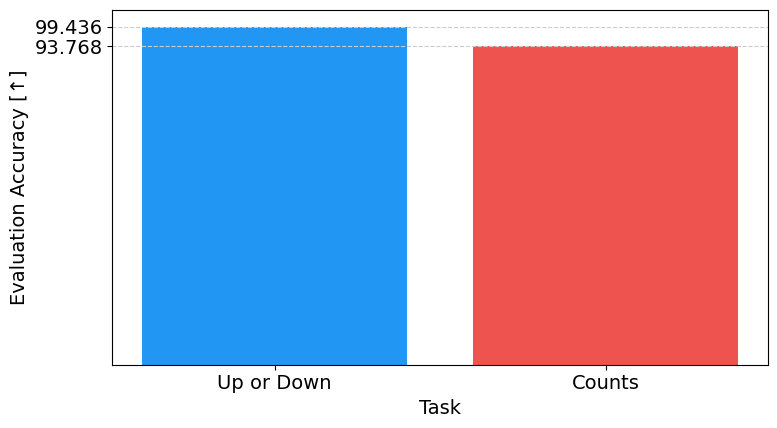

In [11]:
runID = [13, 15]
acc = [100 * rTable.loc[rid]["accuracy"] for rid in runID]
names = ["Up or Down", "Counts"]
plt.bar(names, acc, color=COLORS[:2])
plt.yticks(acc)
# plt.ylim(53., 54.5)
plt.ylabel("Evaluation Accuracy [↑]")
plt.grid(axis="y")
plt.xlabel("Task")
if OUT_FIGS is not None:
    plt.subplots_adjust(bottom=0.15, left=0.15)
    plt.tight_layout()
    plt.savefig(f"{OUT_FIGS}/tasks.svg")

A we can see, the model is really good at extracting patterns and *reasoning*. This suggest that the task is difficult. (Which is intuitive)

# Different market, different distribution?
For all previous experiments, we did them on the taiwan stock market. However, the US stock market is more interesting because it contains more stocks and more liquidity. This is why we would like to see how the model perform on an other market. Will it be better or worst? To keep analog condition, we made a dataset of the 50 most valuable US compagnies. TW50 is the same, but for taiwanese stocks.

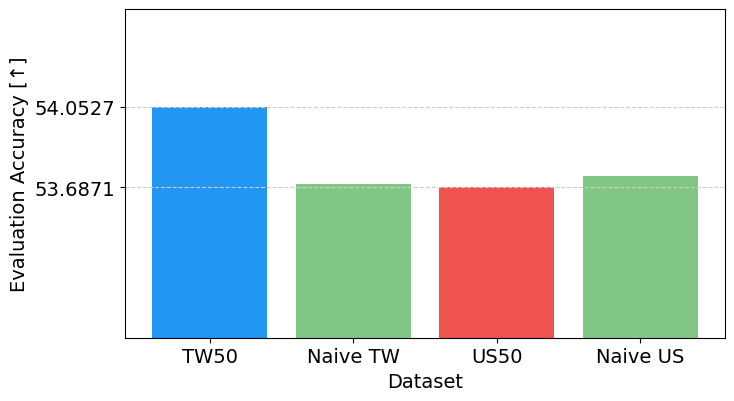

In [12]:
runID = [11, 16]
acc = [100 * rTable.loc[rid]["accuracy"] for rid in runID]
names = ["TW50", "Naive TW", "US50", "Naive US"]
plt.bar(names, [acc[0], NAIVE_PERF["small"], acc[1], NAIVE_PERF["smallUS"]], color=[COLORS[0], COLORS[2], COLORS[1], COLORS[2]])
plt.yticks(acc)
plt.ylim(53., 54.5)
plt.ylabel("Evaluation Accuracy [↑]")
plt.grid(axis="y")
plt.xlabel("Dataset")
if OUT_FIGS is not None:
    plt.subplots_adjust(bottom=0.15, left=0.15)
    plt.savefig(f"{OUT_FIGS}/diff_market.svg")

['Step/Loss', 'Step/accuracy', 'Step/precision', 'Train/accuracy', 'Train/precision', 'Train/Loss', 'Valid/accuracy', 'Valid/precision', 'Valid/Loss']


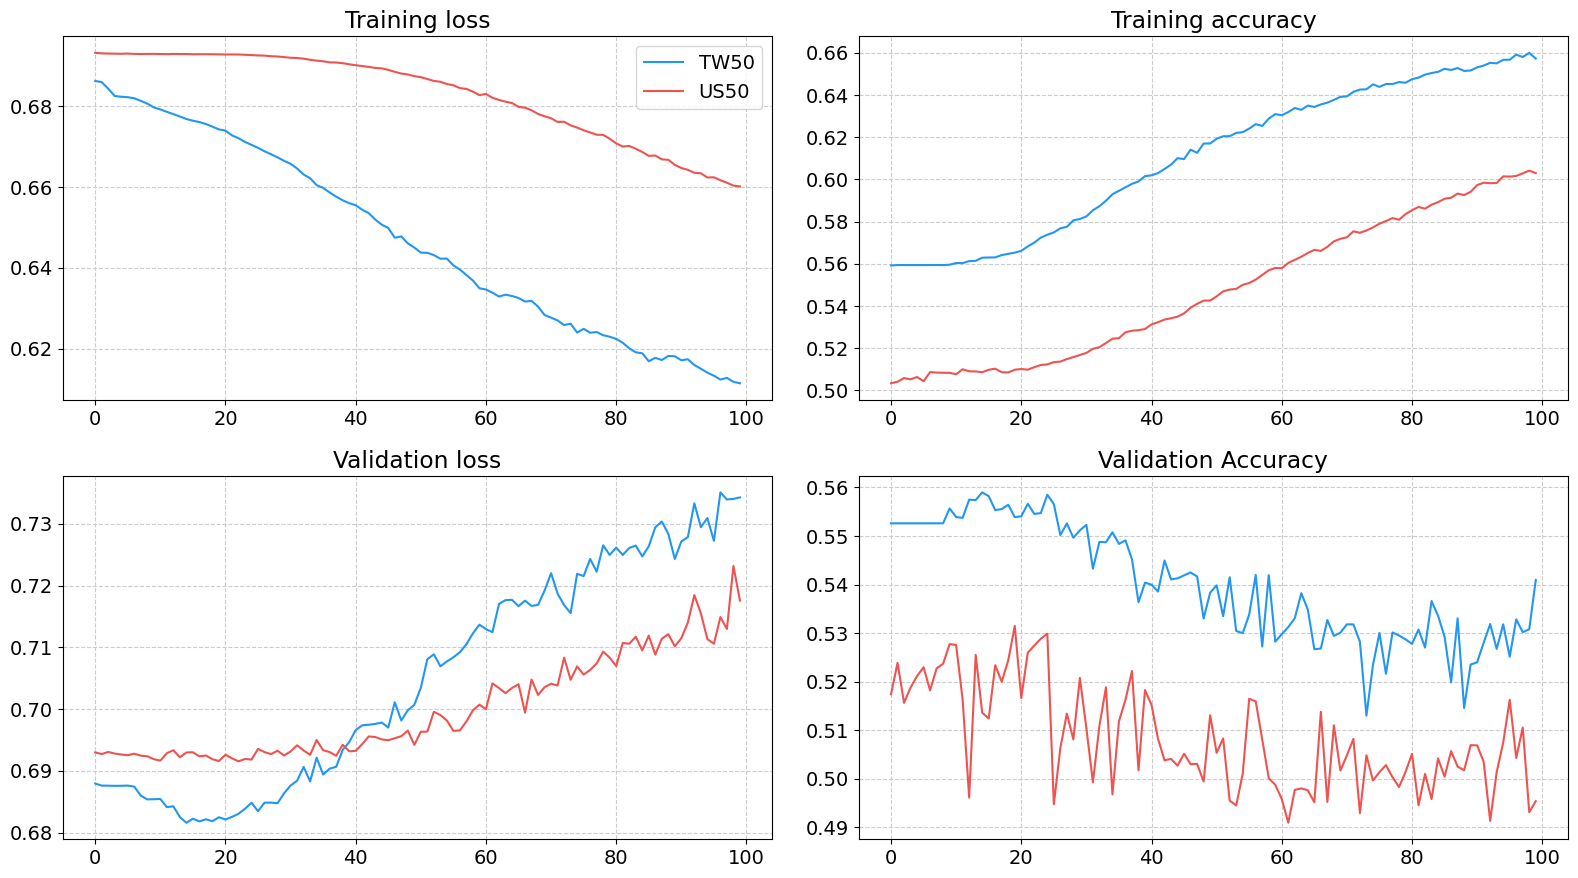

In [13]:
reporterTW = Reporter(log_dir=f'runs/{runID[0]}')
reporterUS = Reporter(log_dir=f'runs/{runID[1]}')
print(reporterUS.keys)
# Load values
train_loss_tw = reporterTW["Train/Loss"]["value"].values
train_loss_us = reporterUS["Train/Loss"]["value"].values
train_acc_tw = reporterTW["Train/accuracy"]["value"].values
train_acc_us = reporterUS["Train/accuracy"]["value"].values
val_loss_tw = reporterTW["Valid/Loss"]["value"].values
val_loss_us = reporterUS["Valid/Loss"]["value"].values
val_acc_tw = reporterTW["Valid/accuracy"]["value"].values
val_acc_us = reporterUS["Valid/accuracy"]["value"].values

# Plot
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

ax[0, 0].plot(train_loss_tw, label="TW50")
ax[0, 0].plot(train_loss_us, label="US50")
ax[0, 0].set_title("Training loss")
ax[0, 0].grid()
ax[0, 0].legend()
ax[0, 1].plot(train_acc_tw, label="TW50")
ax[0, 1].plot(train_acc_us, label="US50")
ax[0, 1].set_title("Training accuracy")
ax[0, 1].grid()
ax[1, 0].plot(val_loss_tw, label="TW50")
ax[1, 0].plot(val_loss_us, label="US50")
ax[1, 0].set_title("Validation loss")
ax[1, 0].grid()
ax[1, 1].plot(val_acc_tw, label="TW50")
ax[1, 1].plot(val_acc_us, label="US50")
ax[1, 1].set_title("Validation Accuracy")
ax[1, 1].grid()
if OUT_FIGS is not None:
    # plt.subplots_adjust(bottom=0.15, left=0.20)
    plt.tight_layout()
    plt.savefig(f"{OUT_FIGS}/learning_curves.svg")

Again, similar performances, but different training dynamic. This suggest a fundamental difference between both datset. (Domain shift)

# Different model

Next, we try a more capable model. Afterall, maybe it is just that the model doesn't have the capacity to learn the task
- Take a SOTA CV model
- EfficietNetV2 small (20M parameters VS 0.35M)

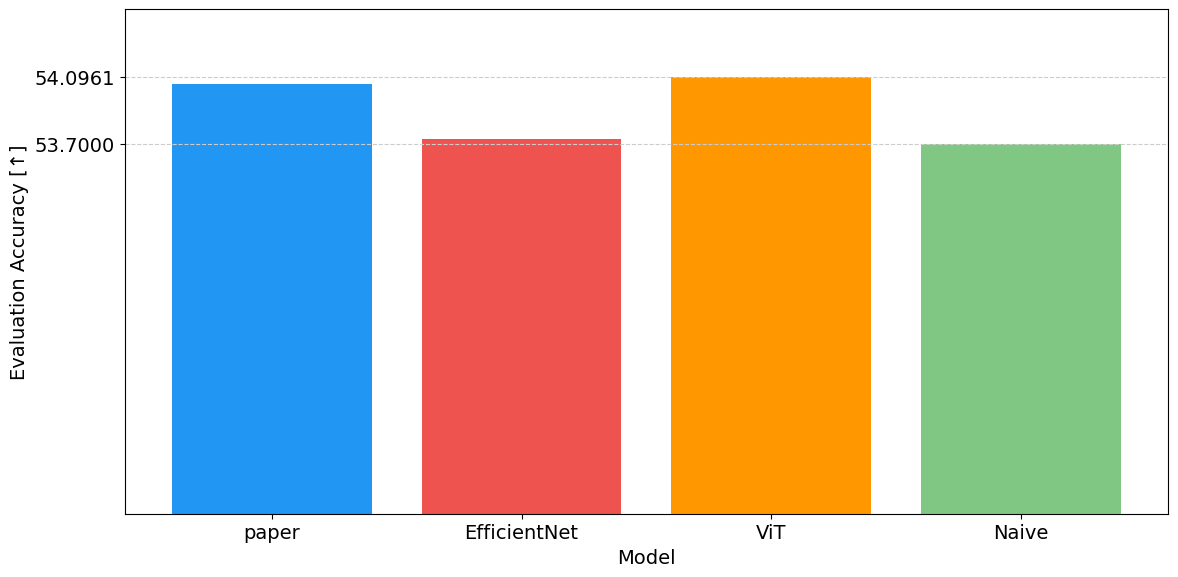

In [14]:
# TW50
runID = [11, 18, 35]
acc = [100 * rTable.loc[rid]["accuracy"] for rid in runID]
names = ["paper", "EfficientNet", "ViT", "Naive"]
fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.bar(names, acc + [NAIVE_PERF["small"]], color=COLORS[:2] + [COLORS[3], COLORS[2]])
ax.set_yticks([acc[2], NAIVE_PERF["small"]])
ax.set_ylim(51.5, 54.5)
ax.set_ylabel("Evaluation Accuracy [↑]")
plt.grid(axis="y")
ax.set_xlabel("Model")
if OUT_FIGS is not None:
    plt.subplots_adjust(bottom=0.15, left=0.15)
    plt.tight_layout()
    plt.savefig(f"{OUT_FIGS}/diff_models.svg")

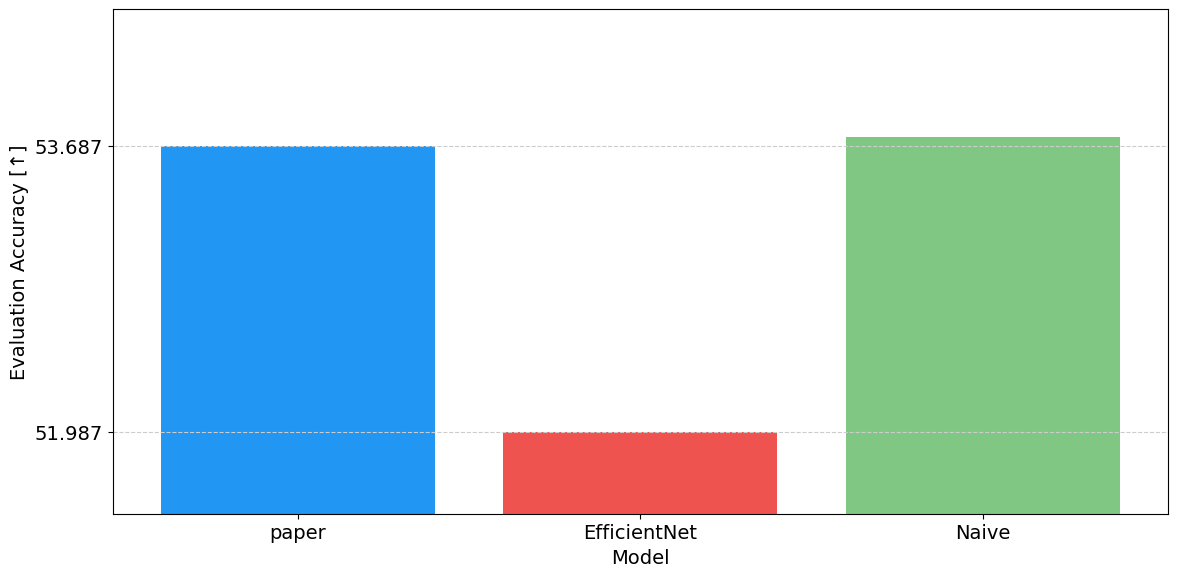

In [15]:
# US50
runID = [16, 17]
acc = [100 * rTable.loc[rid]["accuracy"] for rid in runID]
names = ["paper", "EfficientNet", "Naive"]
fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.bar(names, acc + [NAIVE_PERF["smallUS"]], color=COLORS[:2] + [COLORS[2]])
ax.set_yticks([acc[0], acc[-1]])
ax.set_ylim(51.5, 54.5)
ax.set_ylabel("Evaluation Accuracy [↑]")
plt.grid(axis="y")
ax.set_xlabel("Model")
if OUT_FIGS is not None:
    plt.subplots_adjust(bottom=0.15, left=0.15)
    plt.tight_layout()
    plt.savefig(f"{OUT_FIGS}/diff_models.svg")

By looking at learning curves, we notice all the models were overfitting. Mainly EfficientNet. We can also notice that the models are worst than naive performances on the US50 dataset. This mich be cause by the bias in the dataset. In fact, if the stocks are now in the top 50 stocks, it might be because they increased a lot in the few last years. However, in the begining (training set), they should be average performers. This creates a distribution shift.

# Bigger dataset
Next, we wanted to evaluate how the dataset size would improve the evaluation performances, we trained on a dataset 8x bigger. (10% of all US stocks)

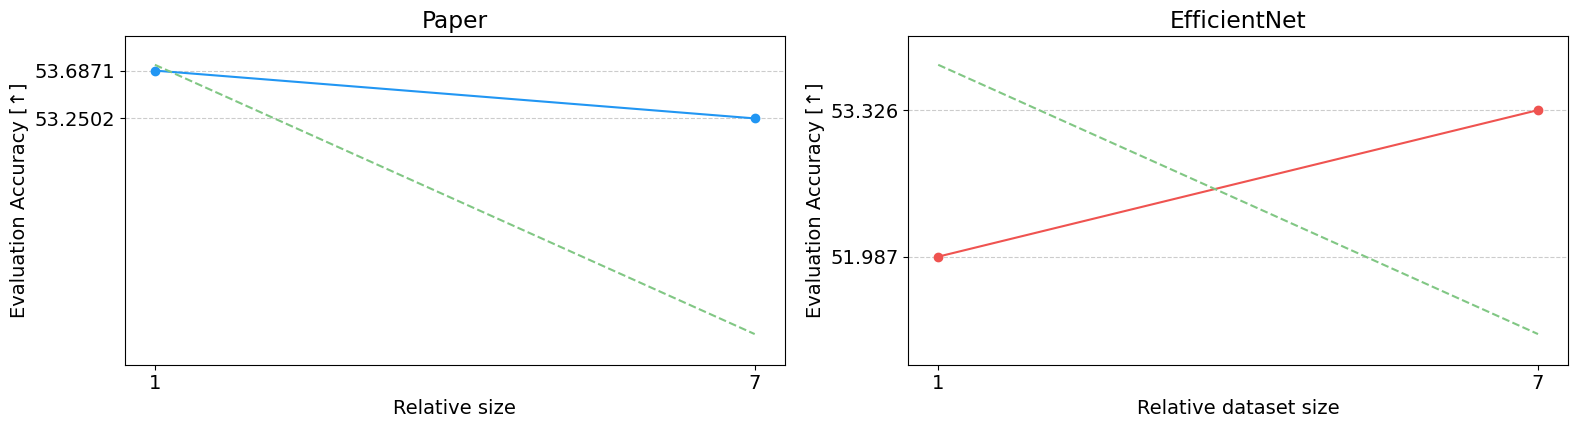

In [16]:
ds_size = [1, 7]
runID = [16, 21]
acc = [100 * rTable.loc[rid]["accuracy"] for rid in runID]
fig, axs = plt.subplots(1, 2, figsize=(16, 4.5))
axs[0].plot(ds_size, acc, marker="o", color=COLORS[0])
axs[0].set_yticks(acc)
axs[0].set_ylim(51, 54)
axs[0].set_ylabel("Evaluation Accuracy [↑]")
axs[0].set_xticks(ds_size)
axs[0].set_xlabel("Relative size")
axs[0].grid(axis='y')
axs[0].set_title("Paper")
axs[0].plot([1, 7], [NAIVE_PERF["smallUS"], NAIVE_PERF["huge0.1"]], color=COLORS[2], linestyle="--")

runID = [17, 20]
acc = [100 * rTable.loc[rid]["accuracy"] for rid in runID]
axs[1].plot(ds_size, acc, marker="o", color=COLORS[1])
axs[1].set_yticks(acc)
axs[1].set_ylim(51, 54)
axs[1].set_ylabel("Evaluation Accuracy [↑]")
axs[1].set_xticks(ds_size)
axs[1].set_xlabel("Relative dataset size")
axs[1].grid(axis='y')
axs[1].set_title("EfficientNet")
axs[1].plot([1, 7], [NAIVE_PERF["smallUS"], NAIVE_PERF["huge0.1"]], color=COLORS[2], linestyle="--")
plt.subplots_adjust(wspace=0.4)
if OUT_FIGS is not None:
    # plt.subplots_adjust(bottom=0.15, left=0.20)
    plt.tight_layout()
    plt.savefig(f"{OUT_FIGS}/bigger_ds.svg")

Makes sense, The bigger model gets an improvment while the smaller doesn't change much. However, we can see in the learning curves that there is still a lot of overfitting for the EfficientNet

# Subsampling
Next, we wil try to subsample (Instead of use day, we will group them together to see if it reduces the noise. We kkep the window size the same shape i. e. 20. We keep the same dataset size

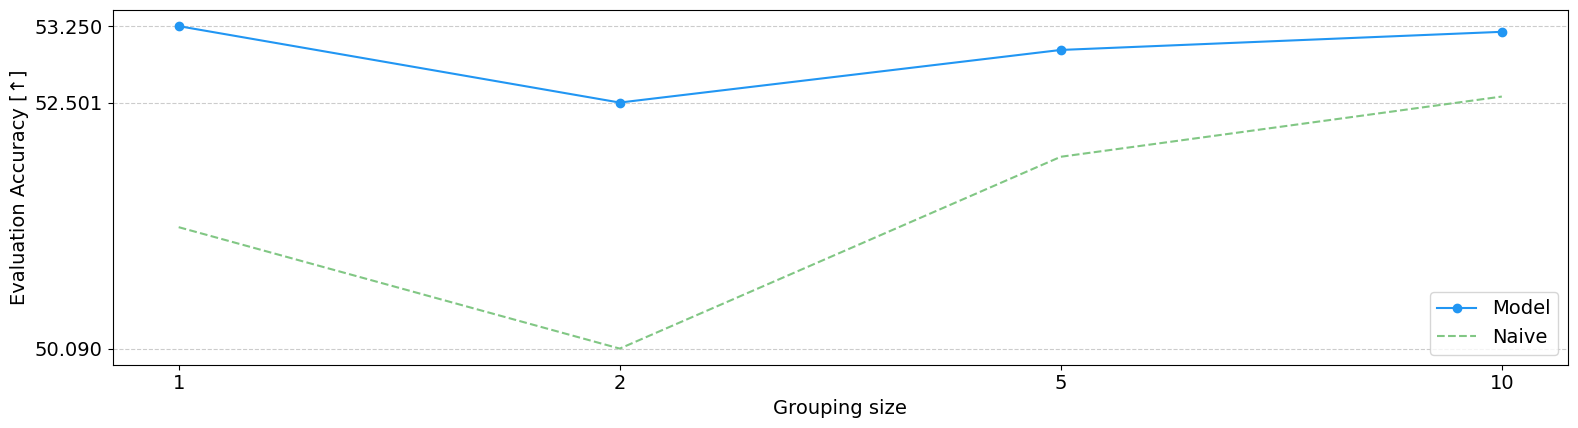

In [17]:
ds_size = [1, 2, 5, 10]
runID = [21, 22, 23, 24]
acc = [100 * rTable.loc[rid]["accuracy"] for rid in runID]
naive_acc = [NAIVE_PERF["huge0.1"], NAIVE_PERF["huge2d0.1"], NAIVE_PERF["huge5d0.1"], NAIVE_PERF["huge10d0.1"]]
fig, axs = plt.subplots(1, 1, figsize=(16, 4.5))
axs.plot([1,2,3,4], acc, marker="o", color=COLORS[0], label="Model")
axs.plot([1,2,3,4], naive_acc, color=COLORS[2], linestyle="--", label="Naive")
axs.set_yticks([acc[0], acc[1], naive_acc[1]])
# axs.set_ylim(51, 54)
axs.set_ylabel("Evaluation Accuracy [↑]")
axs.set_xticks([1,2,3,4], ds_size)
axs.set_xlabel("Grouping size")
axs.grid(axis='y')
axs.legend(loc="lower right")
if OUT_FIGS is not None:
    # plt.subplots_adjust(bottom=0.15, left=0.20)
    plt.tight_layout()
    plt.savefig(f"{OUT_FIGS}/group_size.svg")

Next, we try the same experiment, but we scale the dataset size to accound for the lost of samples. This means thyat the number of training/valid/test samples stays the same

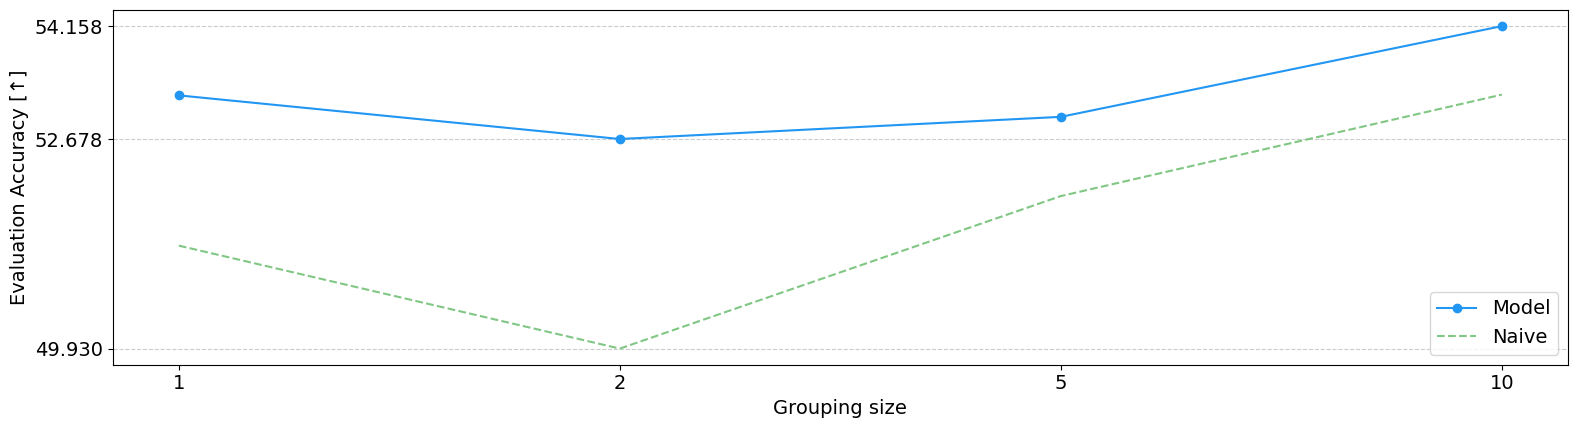

In [18]:
ds_size = [1, 2, 5, 10]
runID = [21, 25, 26, 27]
acc = [100 * rTable.loc[rid]["accuracy"] for rid in runID]
naive_acc = [NAIVE_PERF["huge0.1"], NAIVE_PERF["huge2d0.2"], NAIVE_PERF["huge5d0.5"], NAIVE_PERF["huge10d1."]]
fig, axs = plt.subplots(1, 1, figsize=(16, 4.5))
axs.plot([1,2,3,4], acc, marker="o", color=COLORS[0], label="Model")
axs.plot([1,2,3,4], naive_acc, color=COLORS[2], linestyle="--", label="Naive")
axs.set_yticks([naive_acc[1], acc[1], acc[3]])
# axs.set_ylim(51, 54)
axs.set_ylabel("Evaluation Accuracy [↑]")
axs.set_xticks([1,2,3,4], ds_size)
axs.set_xlabel("Grouping size")
axs.grid(axis='y')
axs.legend(loc="lower right")
if OUT_FIGS is not None:
    # plt.subplots_adjust(bottom=0.15, left=0.20)
    plt.tight_layout()
    plt.savefig(f"{OUT_FIGS}/group_size_bigger_ds.svg")

# Comparaison with other algorithms
The classic *de facto* algorithm in quanbtitative finance are classical ML algiorithmes such as randomForest.  
**TODO: Cite paper**  
We used the features of paper X on 10% of US stocks, and compared it to our model

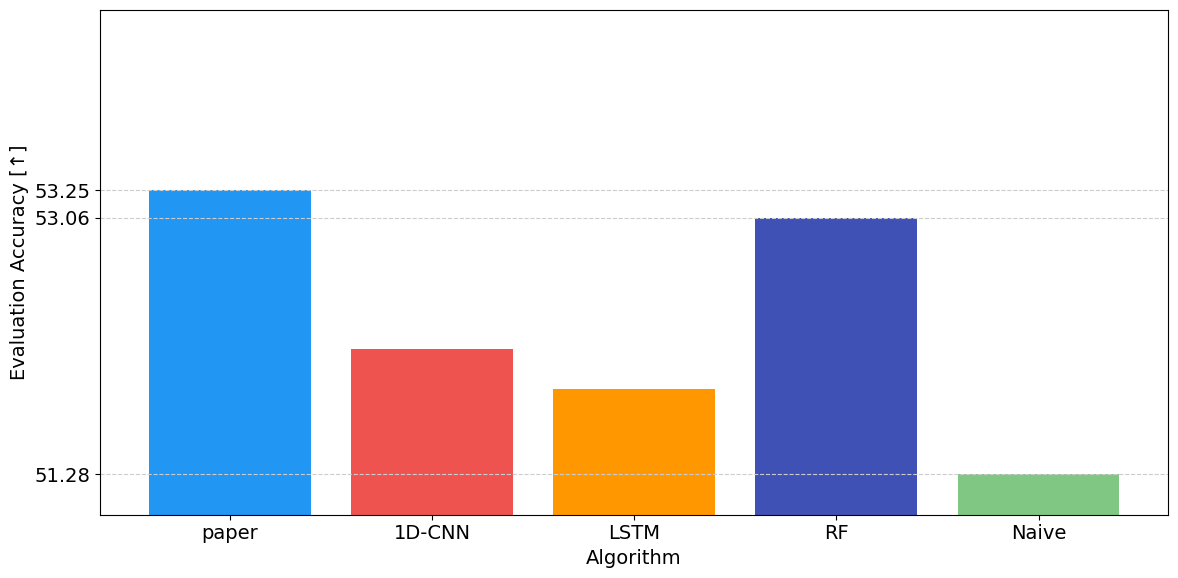

In [19]:
runID = [21, 29, 31]
acc = [100 * rTable.loc[rid]["accuracy"] for rid in runID] + [53.06]
names = ["paper", "1D-CNN", "LSTM", "RF", "Naive"]
fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.bar(names, acc + [NAIVE_PERF["huge0.1"]], color=COLORS[:2] + COLORS[3:5] + [COLORS[2]])
ax.set_yticks([acc[0], acc[-1], NAIVE_PERF["huge0.1"]])
ax.set_ylim(51., 54.5)
ax.set_ylabel("Evaluation Accuracy [↑]")
plt.grid(axis="y")
ax.set_xlabel("Algorithm")
if OUT_FIGS is not None:
    plt.subplots_adjust(bottom=0.15, left=0.15)
    plt.tight_layout()
    plt.savefig(f"{OUT_FIGS}/cnn_vs_other.svg")

The paper cited by this paper to which it compares itself uses a random train test split. Hypothesis: (Which causes dataleaking)

# Evaluate the realisticnesse of a 92.2% accuracy

In [20]:
import matplotlib.pyplot as plt
from backtest.data import JSONCache, FetchCharts, Cache, FilterNoneCharts, CausalImpute
from pipes import Finviz, RmTz, FromFile
import numpy as np
import pandas as pd
from datetime import datetime

def expected_perf(chart: pd.DataFrame, p: float = 1., filterq: float = 1):
    annot = (chart["Close"].shift(-1) > chart["Open"]).iloc[:-1].values.astype(float)  # Tomorrow > today

    if p < 1:
        # Alter annotation
        rnd = np.random.rand(len(annot))
        flip_mask = rnd < 1 - p
        annot[flip_mask] = 1 - annot[flip_mask]

    o, c = chart["Open"].iloc[:-1], chart["Close"].shift(-1).iloc[:-1]
    profits = c[annot == 1] / o[annot == 1]

    quantile = [filterq, 5.0, 10.0, 25.0, 50.0, 75.0, 90.0, 95.0, 100 - filterq]
    percentiles = np.percentile(a=profits, q=quantile)
    profits_filtered = profits[np.logical_and(profits > percentiles[0], profits < percentiles[-1])]

    return profits, profits_filtered, percentiles, quantile

pipe = Finviz("https://finviz.com/screener.ashx?v=111&f=ipodate_more10",True) | JSONCache() | \
               FetchCharts(progress=True, throttle=1., auto_adjust=False) | \
               Cache() | FilterNoneCharts() | RmTz() | CausalImpute()
data = pipe.get(datetime(2000, 1, 1), datetime(2020, 1, 1))

Maximum - Duration Quantile:1 -> 1.000519931303282
Maximum - Duration Quantile:5.0 -> 1.0010252200373566
Maximum - Duration Quantile:10.0 -> 1.0019262525595662
Maximum - Duration Quantile:25.0 -> 1.0061267670594831
Maximum - Duration Quantile:50.0 -> 1.012700591553338
Maximum - Duration Quantile:75.0 -> 1.0204661260236907
Maximum - Duration Quantile:90.0 -> 1.0310105724509138
Maximum - Duration Quantile:95.0 -> 1.0395701394279055
Maximum - Duration Quantile:99 -> 1.0488356276440352
Maximum Expected gain:  8.845865770291606
Paper - Duration Quantile:1 -> 0.990531877000753
Paper - Duration Quantile:5.0 -> 1.0004702326243124
Paper - Duration Quantile:10.0 -> 1.0013589907510292
Paper - Duration Quantile:25.0 -> 1.0059433703152638
Paper - Duration Quantile:50.0 -> 1.012216112245419
Paper - Duration Quantile:75.0 -> 1.0181604307946441
Paper - Duration Quantile:90.0 -> 1.0297263432858836
Paper - Duration Quantile:95.0 -> 1.0386169543080617
Paper - Duration Quantile:99 -> 1.0489610196828068
Pa

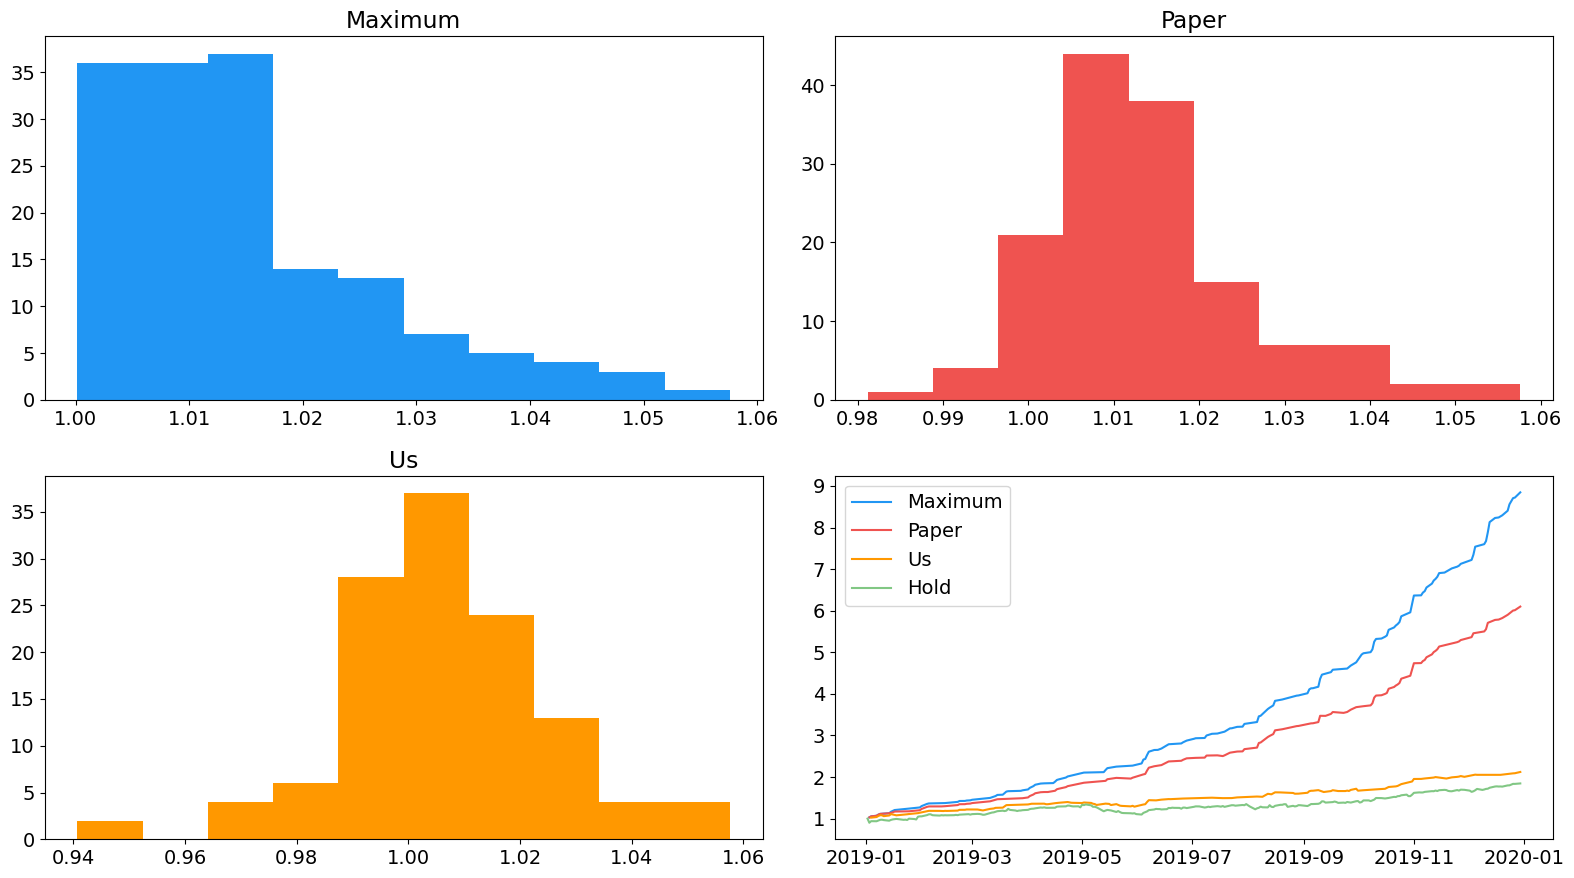

In [26]:
chart = data["AAPL"].loc[datetime(2019, 1, 1).date():].drop(columns=["Dividends", "Stock Splits", "Adj Close"])


profits, profits_filtered, percentiles, quantile = expected_perf(chart)
profits_paper, profits_filtered_paper, percentiles_paper, _ = expected_perf(chart, p=0.922)
profits_us, profits_filtered_us, percentiles_us, _ = expected_perf(chart, p=0.5332)

for i in range(len(quantile)):
    print(f'Maximum - Duration Quantile:{quantile[i]} -> {percentiles[i]}')
print("Maximum Expected gain: ", np.prod(profits_filtered))

for i in range(len(quantile)):
    print(f'Paper - Duration Quantile:{quantile[i]} -> {percentiles_paper[i]}')
print("Paper Expected gain: ", np.prod(profits_filtered_paper))

for i in range(len(quantile)):
    print(f'Our - Duration Quantile:{quantile[i]} -> {percentiles_us[i]}')
print("Our Expected gain: ", np.prod(profits_filtered_us))


fig, axs = plt.subplots(2, 2, figsize=(16, 9))
axs[0, 0].hist(profits)
axs[0, 0].set_title("Maximum")

axs[0, 1].hist(profits_paper, color=COLORS[1])
axs[0, 1].set_title("Paper")

axs[1, 0].hist(profits_us, color=COLORS[3])
axs[1, 0].set_title("Us")

axs[1, 1].plot(np.cumprod(profits_filtered), label="Maximum")
axs[1, 1].plot(np.cumprod(profits_filtered_paper), label="Paper", color=COLORS[1])
axs[1, 1].plot(np.cumprod(profits_filtered_us), label="Us", color=COLORS[3])
axs[1, 1].plot(chart["Close"].iloc[:-1] / chart["Close"].iloc[0], label="Hold", color=COLORS[2])
plt.tight_layout()
plt.legend()
if OUT_FIGS is not None:
    plt.subplots_adjust(bottom=0.15, left=0.15)
    plt.tight_layout()
    plt.savefig(f"{OUT_FIGS}/expected_gain.svg")